# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the CSV files in `data/mimic-iii/final`, extracted using the MIMIC-CODE library, in order to be used by our reinforcement learning agent. In particular this notebook will decribe the preprocessing for the **handcrafted state-space** appraoch as described in [Roggeveen et al.](https://www.sciencedirect.com/science/article/pii/S0933365720312689).

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm

DATA_DIR = '../data/mimic-iii/final/'

---
## Patient Cohort

Using MIMIC-CODE we have extracted a Sepsis-3 cohort (i.e. a list of patients satisfying the Sepsis-3 criteria) along with information regarding the suspected time of infection. Let's first import these data;

In [2]:
cohort_df = pd.read_csv(DATA_DIR + 'cohort.csv')
cohort_df['window_start'] = pd.to_datetime(cohort_df['window_start'])#.dt.floor(freq='4H') # maximize start/stop range
cohort_df['window_end'] = pd.to_datetime(cohort_df['window_end'])#.dt.ceil(freq='4H')

cohort_df.head(8)

,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,10006,142345,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 15:30:00,2164-10-22 15:30:00,2164-10-25 15:30:00,0
1,10013,165520,264446,2125-10-04 23:38:00,2125-10-07 15:13:52,2125-10-05 02:00:00,2125-10-04 02:00:00,2125-10-07 02:00:00,1
2,10017,199207,204881,2149-05-29 18:52:29,2149-05-31 22:19:17,2149-05-27 05:15:00,2149-05-26 05:15:00,2149-05-29 05:15:00,0
3,10019,177759,228977,2163-05-14 20:43:56,2163-05-16 03:47:04,2163-05-14 21:52:00,2163-05-13 21:52:00,2163-05-16 21:52:00,1
4,10026,103770,277021,2195-05-17 07:40:18,2195-05-19 17:24:25,2195-05-17 09:12:00,2195-05-16 09:12:00,2195-05-19 09:12:00,0
5,10029,132349,226055,2139-09-23 12:37:10,2139-09-25 18:55:04,2139-09-22 11:10:00,2139-09-21 11:10:00,2139-09-24 11:10:00,0
6,10032,140372,267090,2138-04-08 01:38:18,2138-04-11 18:43:34,2138-04-08 10:15:00,2138-04-07 10:15:00,2138-04-10 10:15:00,0
7,10036,189483,227834,2185-03-24 16:57:05,2185-03-26 12:18:56,2185-03-24 13:00:00,2185-03-23 13:00:00,2185-03-26 13:00:00,1


---
Let's see how many ICU stays (i.e. patients) exhibit signs of Sepsis-3

In [3]:
valid_icustays = cohort_df['icustay_id'].values
valid_icustays.size

60

We will collect features in an, as of yet, unpopulated dictionary `data_all`, mapping from each `icustay_id` to the corresponding sequences of vitals, lab results and actions (i.e. maximum vasopressor and IV fluid intake);

In [4]:
data_all = {icustay_id:dict() for icustay_id in cohort_df['icustay_id'].values}

# See? empty...
assert data_all[210989] == {}

---

## Compute Time Intervals of 4 Hours

First, for each time interval `(window_start, window_end)` we will precompute all intermediate time steps in increments of 4 hours. Each time we add our output to `data_all`;

In [5]:
# Samples 4h interval from start to end
def get_4h_intervals(start, end):
    return pd.date_range(start=start, end=end, freq='4H').values
    
icustay_timesteps = {x['icustay_id']: get_4h_intervals(x['window_start'], x['window_end']) for _, x in cohort_df.iterrows()}

In [6]:
# Add to `data_all`
for icustay_id, timesteps in icustay_timesteps.items():
    data_all[icustay_id]['Timesteps'] = timesteps
    
data_all[210989]['Timesteps']

array(['2144-07-10T17:57:00.000000000', '2144-07-10T21:57:00.000000000',
       '2144-07-11T01:57:00.000000000', '2144-07-11T05:57:00.000000000',
       '2144-07-11T09:57:00.000000000', '2144-07-11T13:57:00.000000000',
       '2144-07-11T17:57:00.000000000', '2144-07-11T21:57:00.000000000',
       '2144-07-12T01:57:00.000000000', '2144-07-12T05:57:00.000000000',
       '2144-07-12T09:57:00.000000000', '2144-07-12T13:57:00.000000000',
       '2144-07-12T17:57:00.000000000', '2144-07-12T21:57:00.000000000',
       '2144-07-13T01:57:00.000000000', '2144-07-13T05:57:00.000000000',
       '2144-07-13T09:57:00.000000000', '2144-07-13T13:57:00.000000000',
       '2144-07-13T17:57:00.000000000'], dtype='datetime64[ns]')

---
## Vasopressors!

### 1. Process MetaVision (MV) Records

**TODO: Process CareVue data**

In [7]:
# MetaVision
vaso_mv_df = pd.read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df['starttime'] = pd.to_datetime(vaso_mv_df['starttime'])
vaso_mv_df['endtime'] = pd.to_datetime(vaso_mv_df['endtime'])
vaso_mv_df

,icustay_id,starttime,endtime,rate,rateuom,patientweight,vasoactive_drug,mcgkgmin,mcgmin
0,210989,2144-07-13 11:15:00,2144-07-13 11:30:00,8.013029,mcg/kg/min,81.7,dopamine,0.080130,6.546645
1,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,0.502150,mcg/kg/min,81.7,norepinephrine,0.502150,41.025643
2,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,10.012087,mcg/kg/min,81.7,dopamine,0.100121,8.179875
3,210989,2144-07-13 11:50:00,2144-07-13 11:55:00,0.251075,mcg/kg/min,81.7,norepinephrine,0.251075,20.512822
4,210989,2144-07-13 11:55:00,2144-07-13 19:06:00,0.200979,mcg/kg/min,81.7,norepinephrine,0.200979,16.419956
...,...,...,...,...,...,...,...,...,...
293,298685,2166-02-20 14:45:00,2166-02-20 18:00:00,3.107517,mcg/kg/min,52.0,dopamine,0.031075,1.615909
294,298685,2166-02-20 18:00:00,2166-02-20 22:30:00,1.253085,mcg/kg/min,52.0,dopamine,0.012531,0.651604
295,298685,2166-02-20 22:30:00,2166-02-20 23:16:00,1.002422,mcg/kg/min,52.0,dopamine,0.010024,0.521260
296,298685,2166-02-21 05:32:00,2166-02-21 05:55:00,2.000080,mcg/kg/min,52.0,dopamine,0.020001,1.040042


In [8]:
# Consider ICU stays one-by-one
for icustay_id, icustay_data in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    timesteps = icustay_timesteps[icustay_id]
    max_vaso = np.zeros(len(timesteps), dtype=np.float64)
    
    # Which medications were administered in the last 4 hours (window)?
    for i, window_end in enumerate(timesteps):
        window_start = window_end - np.timedelta64(4,'h')
        
        # Inclusion test: vaso administration ends in last 4h interval or after.
        # NOTE: original R-code erroneously used 'endtime < window_end'
        condition = (icustay_data['starttime'] <= window_end) & (icustay_data['endtime'] > window_start)
        interval_vaso_df = icustay_data.loc[condition]
        
        # Compute max vaso (norepinephrine-equivalent)
        max_vaso[i] = interval_vaso_df['mcgkgmin'].max() # (Question: Shouldn't it be sum to be closer to IRL?)
        
    # Fill NaNs with zero (=> no treatment)
    max_vaso = np.nan_to_num(max_vaso, nan=0)
    
    data_all[icustay_id]['MaxVaso'] = max_vaso

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 60.71it/s]


In [10]:
data_all[239396]['MaxVaso']

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08002962, 0.12003111, 0.13990203, 0.10297638,
       0.10297638, 0.20046026, 0.2491954 , 0.2491954 , 0.25149818,
       0.25146934, 0.22162817, 0.24435711, 0.24435711])

## Fluids

### 1. MetaVision

In [11]:
# Load data
ivfluid_mv_df = pd.read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')
ivfluid_mv_df['starttime'] = pd.to_datetime(ivfluid_mv_df['starttime'])
ivfluid_mv_df['endtime'] = pd.to_datetime(ivfluid_mv_df['endtime'])

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water)
condition = (ivfluid_mv_df['ordercategoryname'] != '14-Oral/Gastric Intake') & (ivfluid_mv_df['amountuom'] == 'ml')
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Remove amount outside (0, 5000) range
condition = (ivfluid_mv_df['amount'] > 0) & (ivfluid_mv_df['amount'] < 5000)
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Compute duration in hours
# NOTE: original erroneously measured time in minutes
ivfluid_mv_df['duration'] = (ivfluid_mv_df['endtime'] - ivfluid_mv_df['starttime']).astype('timedelta64[s]').astype(int) / 3600

# Drop many useless columns
ivfluid_mv_df = ivfluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'amount', 'duration']]
ivfluid_mv_df

,subject_id,hadm_id,icustay_id,starttime,endtime,amount,duration
1,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:07:00,999.999978,7.766667
2,40124,126179,279554,2130-02-04 12:36:00,2130-02-04 18:39:00,907.500000,6.050000
4,40124,126179,279554,2130-02-04 14:46:00,2130-02-05 09:01:00,164.299998,18.250000
5,40124,126179,279554,2130-02-05 11:06:00,2130-02-05 15:06:00,499.999992,4.000000
7,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:21:00,999.999984,8.000000
...,...,...,...,...,...,...,...
12164,44228,103379,217992,2170-12-18 16:36:00,2170-12-18 16:37:00,100.000000,0.016667
12166,44228,103379,217992,2170-12-16 16:37:00,2170-12-16 16:38:00,100.000000,0.016667
12170,44228,103379,217992,2170-12-15 14:30:00,2170-12-15 15:30:00,49.999999,1.000000
12171,44228,103379,217992,2170-12-15 10:15:00,2170-12-15 10:41:00,4.251144,0.433333


In [12]:
# Computes how much of each treatment was administered between window_start and window_end
def total_administration_in_window(window_start, window_end, fluid_df):
    dose_start = fluid_df['starttime']
    dose_end = fluid_df['endtime']
    amount = fluid_df['amount']
    duration = fluid_df['duration']
    rate = amount / duration
    
    # Durations in hours
    window_duration = (window_end - window_start).astype('timedelta64[s]').astype(int) / 3600
    rear_overlap = (dose_end - window_start).astype('timedelta64[s]').astype(int) / 3600
    front_overlap = (window_end - dose_start).astype('timedelta64[s]').astype(int) / 3600
    
    # Option1: Does started before window and ended after window
    c1 = (dose_start < window_start) & (dose_end > window_end)
    total1 = (window_duration * rate[c1]).sum()
    
    # Option2: Dose started before and ended within window
    c2 = (dose_start < window_start) & (dose_end > window_start) & (dose_end <= window_end)
    total2 = (rear_overlap * rate[c2]).sum()
    
    # Option3: Dose started and ended in window
    c3 = (dose_start >= window_start) & (dose_start < window_end) & (dose_end <= window_end) & (dose_end > window_start)
    total3 = amount[c3].sum()
    
    # Option4: Window started before and ended within dose
    c4 = (window_start < dose_start) & (window_end > dose_start) & (window_end < dose_end)
    total4 = (front_overlap * rate[c4]).sum()
            
    return total1 + total2 + total3 + total4
    
    
# Consider ICU stays one-by-one
print('Grab some coffee!')
for icustay_id, icustay_data in tqdm(ivfluid_mv_df.groupby('icustay_id')):
    try:
        timesteps = icustay_timesteps[icustay_id]
    except:
        continue
    
    # To store total fluid intake.
    icustay_total_ivfluid = np.zeros(len(timesteps), dtype=np.float64)
    
    # Which fluids were administered in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        window_start = window_end - np.timedelta64(4, 'h')
        
        # Compute total IV fluid
        icustay_total_ivfluid[i] = total_administration_in_window(window_start, window_end, icustay_data)
        
    # Fill NaNs (with no fluid) should there be any
    icustay_total_ivfluid = np.nan_to_num(icustay_total_ivfluid, nan=0)
        
    # Save!
    data_all[icustay_id]['TotalFluid'] = icustay_total_ivfluid

Grab some coffee!


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 20.35it/s]


In [13]:
data_all[239396]['TotalFluid']

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    8.55091395, 1225.27569371,
        860.8409346 ,  725.24996289,  820.48022881, 1938.17992514,
       1613.47511671,  992.37863358, 1046.19694227, 1359.03226716,
       1405.51168499, 2085.61893275, 1143.43710779])

---
## Vitals

In [14]:
# Load data
vitals_df = pd.read_csv(DATA_DIR + 'vitals_cohort.csv')
vitals_df['window_start'] = pd.to_datetime(vitals_df['window_start'])
vitals_df['window_end'] = pd.to_datetime(vitals_df['window_end'])
vitals_df['intime'] = pd.to_datetime(vitals_df['intime'])
vitals_df['outtime'] = pd.to_datetime(vitals_df['outtime'])
vitals_df['charttime'] = pd.to_datetime(vitals_df['charttime'])
vitals_df.head(10)

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,vital_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,DiasBP,50.000000
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,HeartRate,104.000000
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,MeanBP,63.666698
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,RespRate,25.000000
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,SpO2,98.000000
5,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,SysBP,91.000000
6,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,TempC,37.555555
7,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 23:00:00,DiasBP,50.000000
8,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 23:00:00,HeartRate,99.000000
9,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 23:00:00,MeanBP,63.666698


In [15]:
# Which vitals are included?
ALL_VITAL_IDS = list(set(vitals_df['vital_id']))
ALL_VITAL_IDS

['SysBP',
 'DiasBP',
 'SpO2',
 'Glucose',
 'RespRate',
 'HeartRate',
 'TempC',
 'MeanBP']

---

In [21]:
# Process ICU stays one-by-one
for icustay_id, icustay_data in tqdm(vitals_df.groupby('icustay_id')):
    try:
        timesteps = icustay_timesteps[icustay_id]
    except:
        continue
        
    # Add dict to `data_all` to store aggregated vital measurements
    for vital_id in ALL_VITAL_IDS:
        data_all[icustay_id][vital_id] = np.zeros(len(timesteps), dtype=np.float32)
            
    # Which vitals were monitored in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        
        # Inclusion test: Measurement charttime in (window_start, window_end)
        window_start = window_end - np.timedelta64(4, 'h')
        condition = (icustay_data['charttime'] > window_start) & (icustay_data['charttime'] < window_end)  
        
        # Compute average value of each vital_id
        vital_averages = icustay_data[condition].groupby('vital_id')['valuenum'].mean()
        
        for vital_id, value in vital_averages.iteritems():
            data_all[icustay_id][vital_id][i] = value

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 38.64it/s]


In [22]:
data_all[239396]['MeanBP']

array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
       60.333332, 71.      , 70.      , 67.25    , 69.75    , 77.111115,
       61.42857 , 71.28571 , 69.25    , 68.75    , 72.      , 66.      ,
       65.5     ], dtype=float32)

---
## Labs

In [23]:
# Load data
lab_df = pd.read_csv(DATA_DIR + 'labs_cohort.csv')
lab_df['window_start'] = pd.to_datetime(lab_df['window_start'])
lab_df['window_end'] = pd.to_datetime(lab_df['window_end'])
lab_df['intime'] = pd.to_datetime(lab_df['intime'])
lab_df['outtime'] = pd.to_datetime(lab_df['outtime'])
lab_df['charttime'] = pd.to_datetime(lab_df['charttime'])

# Drop rows with NaNs
lab_df = lab_df.dropna(axis=0)

lab_df.head(10)

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,lab_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:33:00,LACTATE,4.4
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALAT,9.0
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALBUMIN,3.4
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ANION GAP,20.0
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ASAT,40.0
5,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,BICARBONATE,29.0
6,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,BILIRUBIN,1.0
7,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,BUN,9.0
8,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,CALCIUM,9.4
9,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,CHLORIDE,96.0


In [34]:
# Which lab measurements were made?
ALL_LAB_IDS = list(set(lab_df['lab_id'].values))
ALL_LAB_IDS

['PT',
 'BUN',
 'BICARBONATE',
 'ION_CALCIUM',
 'BANDS',
 'PTT',
 'ASAT',
 'PAO2',
 'PH',
 'CALCIUM',
 'PACO2',
 'CREATININE',
 'POTASSIUM',
 'MAGNESIUM',
 'WBC',
 'LACTATE',
 'ALAT',
 'GLUCOSE',
 'CHLORIDE',
 'PLATELET',
 'BaseExcess',
 'ALBUMIN',
 'ANION GAP',
 'HEMOGLOBIN',
 'SODIUM',
 'BILIRUBIN']

In [32]:
# Process ICU stays one-by-one
for icustay_id, icustay_data in tqdm(lab_df.groupby('icustay_id')):
    try:
        timesteps = icustay_timesteps[icustay_id]
    except:
        continue
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    for lab_id in ALL_LAB_IDS:
        data_all[icustay_id][lab_id] = np.zeros(len(timesteps), dtype=np.float32)
            
    # Which vitals were monitored in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        
        # Inclusion test: Measurement charttime in (window_start, window_end)
        window_start = window_end - np.timedelta64(4, 'h')
        condition = (icustay_data['charttime'] > window_start) & (icustay_data['charttime'] <= window_end)  
        
        # Compute average value of each vital_id
        lab_averages = icustay_data[condition].groupby('lab_id')['valuenum'].mean()
        
        for lab_id, value in lab_averages.iteritems():
            data_all[icustay_id][lab_id][i] = value

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 39.74it/s]


In [33]:
data_all[201006]['ALAT']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 37.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

---
## Urine Output

In [46]:
urine_df = pd.read_csv(DATA_DIR + 'urineoutput_cohort.csv')
urine_df['charttime'] = pd.to_datetime(urine_df['charttime'])

# Drop values exceeding 5000 (just in case)
urine_df = urine_df[(urine_df['value'] > 0) & urine_df['value'] < 5000]

urine_df.head(10)

,subject_id,hadm_id,icustay_id,charttime,value
0,10045,126949,203766,2129-11-26 08:00:00,6
1,40310,186361,210989,2144-07-13 06:00:00,10
2,42075,151323,298685,2166-02-13 01:00:00,15
3,10032,140372,267090,2138-04-09 10:00:00,40
4,10044,124073,270154,2152-10-03 11:00:00,200
5,10089,190301,246080,2132-08-07 02:00:00,50
6,42321,114648,201204,2121-12-09 01:00:00,80
7,43881,172454,214180,2104-09-24 22:00:00,950
8,10089,190301,246080,2132-08-07 20:00:00,180
9,10112,188574,224063,2148-01-15 20:00:00,30


In [43]:
# Process ICU stays one-by-one
for icustay_id, icustay_data in tqdm(urine_df.groupby('icustay_id')):
    try:
        timesteps = icustay_timesteps[icustay_id]
    except:
        continue
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    data_all[icustay_id]['UrineOutput'] = np.zeros(len(timesteps), dtype=np.float32)
            
    # Which vitals were monitored in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        
        # Inclusion test: Measurement charttime in (window_start, window_end)
        window_start = window_end - np.timedelta64(4, 'h')
        condition = (icustay_data['charttime'] > window_start) & (icustay_data['charttime'] <= window_end)  
        
        # Compute average value of each vital_id
        data_all[icustay_id]['UrineOutput'][i] = icustay_data[condition]['value'].sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 71.28it/s]


In [48]:
data_all[279554]['UrineOutput']

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 435., 110., 295.,
       640., 930., 700., 845., 835., 640., 655., 760.], dtype=float32)

---
## FiO2 (Fraction Inspired Oxygen)

In [51]:
fio2_df = pd.read_csv(DATA_DIR + 'fio2_cohort.csv')
fio2_df['charttime'] = pd.to_datetime(fio2_df['charttime'])

fio2_df

,subject_id,hadm_id,icustay_id,charttime,fio2
0,10013,165520,264446,2125-10-05 00:00:00,60.000002
1,10013,165520,264446,2125-10-05 01:00:00,40.000001
2,10013,165520,264446,2125-10-05 03:00:00,40.000001
3,10013,165520,264446,2125-10-05 07:00:00,69.999999
4,10013,165520,264446,2125-10-05 10:00:00,69.999999
...,...,...,...,...,...
329,44228,103379,217992,2170-12-16 06:33:00,40.000000
330,44228,103379,217992,2170-12-16 08:00:00,40.000000
331,44228,103379,217992,2170-12-16 10:00:00,40.000000
332,44228,103379,217992,2170-12-16 14:00:00,40.000000


In [53]:
# Process ICU stays one-by-one
for icustay_id, icustay_data in tqdm(fio2_df.groupby('icustay_id')):
    try:
        timesteps = icustay_timesteps[icustay_id]
    except:
        continue
        
    # Add lab_ids to `data_all` to store aggregated lab measurements
    data_all[icustay_id]['FiO2'] = np.zeros(len(timesteps), dtype=np.float32)
            
    # Which vitals were monitored in the last 4 hours?
    for i, window_end in enumerate(timesteps):
        
        # Inclusion test: Measurement charttime in (window_start, window_end)
        window_start = window_end - np.timedelta64(4, 'h')
        condition = (icustay_data['charttime'] > window_start) & (icustay_data['charttime'] <= window_end)  
        
        # Compute average value of each vital_id
        data_all[icustay_id]['FiO2'][i] = icustay_data[condition]['fio2'].sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 67.64it/s]


In [54]:
data_all[279554]['FiO2']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40., 35.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

---

## Done!

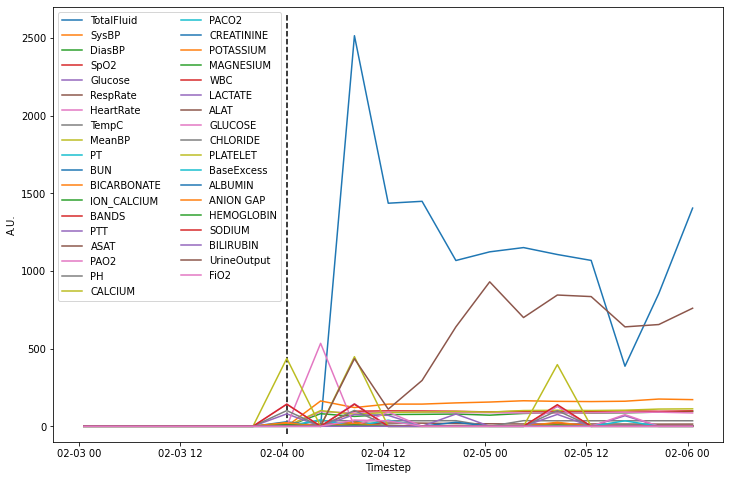

In [78]:
import matplotlib.pyplot as plt

data = data_all[279554]

x = data['Timesteps']

plt.figure(figsize=(12, 8))

# Suspected time of infection
plt.plot([x[6], x[6]], [-50, 2650], color='k', linestyle='--')

# Plots data
for key, y in data.items():
    if key != 'Timesteps':
        plt.plot(x, y, label=key)

plt.ylim(-100, 2700)
plt.xlabel('Timestep')
plt.ylabel('A.U.')
plt.legend(ncol=2)
plt.show()